In [2]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
%pylab inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
# This cell assumes you hav the five_min_frame.hdf which is a hdf output of a pandas dataframe
# of all 2015 data without the lane specific columns
# start_time = time.time()
# df = pd.read_hdf('five_min_frame.hdf','five_min_frame')
# print "total time: %s" % (time.time() - start_time)

total time: 108.548623085


In [3]:
# filter to main line stations only
# df_ml = df[df['Lane Type'] == 'ML']

In [4]:
# df_core = df_ml[['Timestamp', 'Station', 'Freeway #', 'Direction', '% Observed', 'Total Flow', 'Avg Occupancy',
#                  'Avg Speed']]
# df_core.to_hdf('2015_ml_core.hdf', 'ml_core', mode='w')

In [2]:
# If you have the 2015_ml_core.hdf file then start here
df_core = pd.read_hdf('2015_ml_core.hdf', 'ml_core')

In [6]:
no_dup_keep_last = pd.read_hdf('meta_2015.hdf', 'meta_2015')

In [7]:
to_loop = no_dup_keep_last.groupby(['Fwy', 'Dir'])['ID'].count().reset_index()[['Fwy', 'Dir']].values

In [5]:
daymap = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

def add_date_time_weekday( df ):
    """
    Josh's add date_time function
    """
    df.loc[:,'Timestamp2'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')
    df.loc[:,'Time'] = df['Timestamp2'].dt.time
    df.loc[:,'Date'] = df['Timestamp2'].dt.date
    df.loc[:,'Weekday'] = df['Date'].apply( lambda x: daymap[x.weekday()] )
    return df

In [17]:
def create_freeway_day_pivot(Fwy, Dir):
    """
    This function is designed to pivot a particular freeway / direction for a particular type of data
    
    This should probably be refactored, but there were issues pivoting all of the data at one time so
    this approach chunks the data up and then does pivots on the chunks and writes out to disk
    
    Expect this to take a long time...
    """
    print "pivoting Fwy: %s Dir: %s" % (Fwy, Dir)
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekends = ['Saturday', 'Sunday']
    
    if Dir == "N":
        sort_order = ('Abs_PM', True)        
    elif Dir == "S":
        sort_order = ('Abs_PM', False)        
    elif Dir == "E":
        sort_order = ('Abs_PM', True)        
    elif Dir == "W":
        sort_order = ('Abs_PM', False) 

    ret = no_dup_keep_last[(no_dup_keep_last.Fwy == Fwy) & (no_dup_keep_last.Dir == Dir)]\
        .sort_values(by=sort_order[0], ascending=sort_order[1])
    ret.index = np.arange(0, ret.shape[0])
    station_list = list(ret.ID.values)
    stations = df_core.Station.isin(station_list)
    df_stations = df_core[stations]
    stations_with_date = add_date_time_weekday(df_stations)

    if df_stations.Timestamp.count() > 0:
        for col, f_name in [('Total Flow', 'Flow'), ('Avg Occupancy', 'Occu'), ('Avg Speed', 'Speed'), 
                            ('% Observed', 'Obser')]:
    #         for day in daymap.values():
    #             # print "day: %s" % day
    #             df = stations_with_date[stations_with_date.Weekday == day]

    #             # note: only creating flow at this point...
    #             pivoted = df.pivot_table(index='Station', columns='Time', values=col, aggfunc=np.mean)
    #             name = '%s_2015_%s_%s_%s' % (f_name, Fwy, Dir, day)
    #             pivoted.to_hdf('%s.hdf' % (name), name, mode='w')

            for partition, part_name in [(weekdays, 'Weekdays'), (weekends, 'Weekends')]:
                # print "part_name: %s" % part_name
                partition_df = df_stations[ df_stations.Weekday.isin(partition) ]
                pivoted = partition_df.pivot_table(index='Station', columns='Time', values=col, aggfunc=np.mean)
                name = '%s_2015_%s_%s_%s' % (f_name, Fwy, Dir, part_name)
                pivoted.to_hdf('%s.hdf' % (name), name, mode='w')
    else:
        # note: for 2015 D11 this only occurs for the 67 freeway
        print "Fwy: %s Dir: %s has no data" % (Fwy, Dir)

In [18]:
for Fwy, Dir in to_loop:
    start_time = time.time()
    create_freeway_day_pivot(Fwy, Dir)
    print "time: %s" % (time.time() - start_time)

pivoting Fwy: 5 Dir: N


//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:260: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0] [items->None]

  f(store)
//anacon

time: 241.604071856
pivoting Fwy: 5 Dir: S
time: 231.151313066
pivoting Fwy: 8 Dir: E
time: 93.7324228287
pivoting Fwy: 8 Dir: W
time: 104.749070168
pivoting Fwy: 15 Dir: N
time: 164.26560998
pivoting Fwy: 15 Dir: S
time: 162.579260111
pivoting Fwy: 52 Dir: E
time: 43.306363821
pivoting Fwy: 52 Dir: W
time: 49.7747080326
pivoting Fwy: 54 Dir: E
time: 8.50281095505
pivoting Fwy: 54 Dir: W
time: 8.37811398506
pivoting Fwy: 56 Dir: E
time: 27.7345619202
pivoting Fwy: 56 Dir: W
time: 25.0818378925
pivoting Fwy: 67 Dir: N
Fwy: 67 Dir: N has no data
time: 0.913484096527
pivoting Fwy: 67 Dir: S
Fwy: 67 Dir: S has no data
time: 0.934397935867
pivoting Fwy: 78 Dir: E
time: 43.8320848942
pivoting Fwy: 78 Dir: W
time: 59.6569681168
pivoting Fwy: 94 Dir: E
time: 37.475110054
pivoting Fwy: 94 Dir: W
time: 48.9163999557
pivoting Fwy: 125 Dir: N
time: 43.3695590496
pivoting Fwy: 125 Dir: S
time: 45.1521439552
pivoting Fwy: 163 Dir: N
time: 29.8429861069
pivoting Fwy: 163 Dir: S
time: 35.4856250286
pi

In [10]:
# List freeway weekday / weekends
!ls Flow_2015*Week*.hdf

Flow_2015_125_N_Weekdays.hdf Flow_2015_5_S_Weekdays.hdf
Flow_2015_125_N_Weekends.hdf Flow_2015_5_S_Weekends.hdf
Flow_2015_125_S_Weekdays.hdf Flow_2015_67_N_Weekdays.hdf
Flow_2015_125_S_Weekends.hdf Flow_2015_67_N_Weekends.hdf
Flow_2015_15_N_Weekdays.hdf  Flow_2015_67_S_Weekdays.hdf
Flow_2015_15_N_Weekends.hdf  Flow_2015_67_S_Weekends.hdf
Flow_2015_15_S_Weekdays.hdf  Flow_2015_78_E_Weekdays.hdf
Flow_2015_15_S_Weekends.hdf  Flow_2015_78_E_Weekends.hdf
Flow_2015_163_N_Weekdays.hdf Flow_2015_78_W_Weekdays.hdf
Flow_2015_163_N_Weekends.hdf Flow_2015_78_W_Weekends.hdf
Flow_2015_163_S_Weekdays.hdf Flow_2015_805_N_Weekdays.hdf
Flow_2015_163_S_Weekends.hdf Flow_2015_805_N_Weekends.hdf
Flow_2015_52_E_Weekdays.hdf  Flow_2015_805_S_Weekdays.hdf
Flow_2015_52_E_Weekends.hdf  Flow_2015_805_S_Weekends.hdf
Flow_2015_52_W_Weekdays.hdf  Flow_2015_8_E_Weekdays.hdf
Flow_2015_52_W_Weekends.hdf  Flow_2015_8_E_Weekends.hdf
Flow_2015_54_E_Weekdays.hdf  Flow_2015_8_W_Weekdays.hdf
Flow_2015_54_E_Weekends.hdf  Flo

In [12]:
!ls Occ*

Occu_2015_125_N_Weekdays.hdf Occu_2015_5_S_Weekdays.hdf
Occu_2015_125_N_Weekends.hdf Occu_2015_5_S_Weekends.hdf
Occu_2015_125_S_Weekdays.hdf Occu_2015_78_E_Weekdays.hdf
Occu_2015_125_S_Weekends.hdf Occu_2015_78_E_Weekends.hdf
Occu_2015_15_N_Weekdays.hdf  Occu_2015_78_W_Weekdays.hdf
Occu_2015_15_N_Weekends.hdf  Occu_2015_78_W_Weekends.hdf
Occu_2015_15_S_Weekdays.hdf  Occu_2015_805_N_Weekdays.hdf
Occu_2015_15_S_Weekends.hdf  Occu_2015_805_N_Weekends.hdf
Occu_2015_163_N_Weekdays.hdf Occu_2015_805_S_Weekdays.hdf
Occu_2015_163_N_Weekends.hdf Occu_2015_805_S_Weekends.hdf
Occu_2015_163_S_Weekdays.hdf Occu_2015_8_E_Weekdays.hdf
Occu_2015_163_S_Weekends.hdf Occu_2015_8_E_Weekends.hdf
Occu_2015_52_E_Weekdays.hdf  Occu_2015_8_W_Weekdays.hdf
Occu_2015_52_E_Weekends.hdf  Occu_2015_8_W_Weekends.hdf
Occu_2015_52_W_Weekdays.hdf  Occu_2015_905_E_Weekdays.hdf
Occu_2015_52_W_Weekends.hdf  Occu_2015_905_E_Weekends.hdf
Occu_2015_54_E_Weekdays.hdf  Occu_2015_905_W_Weekdays.hdf
Occu_2015_54_E_Weekends.hdf  O

In [ ]:
# create average year dataframes per direction
# Note: for some reason doing the time calculation on the entire year at once never finished, but
# breaking it into directions of N, S, E, W and then doing it worked
for Dir in ['N', 'S', 'E', 'W']:
    sub_frame = df_core[df_core.Direction == Dir]
    new_time = pd.to_datetime(sub_frame['Timestamp'], format='%m/%d/%Y %H:%M:%S').dt.time
    sub_frame['Time'] = new_time
    for col, f_name in [('% Observed', 'Obser')]:            
#     for col, f_name in [('Total Flow', 'Flow'), ('Avg Occupancy', 'Occu'), ('Avg Speed', 'Speed'),
#                        ('% Observed', 'Obser')]:
        pivoted = sub_frame.pivot_table(index='Station', columns='Time', values=col, aggfunc=np.mean)
        name = '%s_%s_2015' % (f_name, Dir)
        pivoted.to_hdf('%s.hdf' % (name), name, mode='w')

In [ ]:
# construct yearly average Flow Speed and Occu vectors from the N, S, E, W
# for data_type in ['Flow', 'Speed', 'Occu', 'Obser']:
for data_type in ['Obser']:    
    files = !ls Flow_*_2015.hdf
    frames = []
    for item in files:
        name = item.split('.')[0]
        frames.append(pd.read_hdf(item, name))
    total = pd.concat(frames)
    total_mean = total.mean()
    total_mean.to_hdf('%s_2015.hdf' % data_type, '%s_2015' % data_type)

In [16]:
!ls Flow_2015_*.hdf

Flow_2015_125_N_Weekdays.hdf Flow_2015_5_N_Weekdays.hdf
Flow_2015_125_N_Weekends.hdf Flow_2015_5_N_Weekends.hdf
Flow_2015_125_S_Weekdays.hdf Flow_2015_5_S_Weekdays.hdf
Flow_2015_125_S_Weekends.hdf Flow_2015_5_S_Weekends.hdf
Flow_2015_15_N_Weekdays.hdf  Flow_2015_78_E_Weekdays.hdf
Flow_2015_15_N_Weekends.hdf  Flow_2015_78_E_Weekends.hdf
Flow_2015_15_S_Weekdays.hdf  Flow_2015_78_W_Weekdays.hdf
Flow_2015_15_S_Weekends.hdf  Flow_2015_78_W_Weekends.hdf
Flow_2015_163_N_Weekdays.hdf Flow_2015_805_N_Weekdays.hdf
Flow_2015_163_N_Weekends.hdf Flow_2015_805_N_Weekends.hdf
Flow_2015_163_S_Weekdays.hdf Flow_2015_805_S_Weekdays.hdf
Flow_2015_163_S_Weekends.hdf Flow_2015_805_S_Weekends.hdf
Flow_2015_52_E_Weekdays.hdf  Flow_2015_8_E_Weekdays.hdf
Flow_2015_52_E_Weekends.hdf  Flow_2015_8_E_Weekends.hdf
Flow_2015_52_W_Weekdays.hdf  Flow_2015_8_W_Weekdays.hdf
Flow_2015_52_W_Weekends.hdf  Flow_2015_8_W_Weekends.hdf
Flow_2015_54_E_Weekdays.hdf  Flow_2015_905_E_Weekdays.hdf
Flow_2015_54_E_Weekends.hdf  Flow_

In [31]:
df.reset_index()

Time,Station,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,...,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00
0,1108299,23.770115,23.624521,22.122605,21.643678,20.524904,20.068966,18.651341,17.383142,17.333333,...,41.305019,40.814672,39.891892,37.749035,34.980695,33.030888,34.108108,35.362934,32.687259,29.555985
1,1108372,59.704981,59.954023,63.498084,63.409962,57.988506,51.911877,48.153257,45.268199,43.398467,...,113.332046,111.451737,106.142857,94.776062,85.540541,81.660232,83.181467,83.378378,79.401544,72.212355
2,1111555,23.716475,23.068966,21.114943,20.789272,20.620690,19.839080,19.045977,17.532567,16.655172,...,39.787645,39.895753,38.864865,37.629344,34.606178,32.007722,33.050193,33.733591,32.996139,29.722008
3,1111557,28.586207,27.494253,26.068966,25.873563,24.528736,23.946360,22.954023,20.934866,20.026820,...,48.725869,48.235521,47.312741,45.644788,42.138996,41.007722,40.629344,40.706564,39.833977,35.478764
4,1112964,37.103448,37.015326,37.088123,37.942529,35.279693,32.720307,30.421456,28.095785,27.076628,...,67.189189,67.189189,61.498069,55.729730,53.467181,50.366795,52.583012,49.494208,47.826255,45.204633
5,1113017,38.762452,39.122605,38.091954,38.436782,37.011494,34.532567,31.984674,30.892720,28.796935,...,70.451737,70.382239,64.501931,58.741313,56.741313,54.003861,53.451737,50.903475,47.166023,44.420849
6,1113147,46.957854,46.773946,45.325670,45.659004,43.321839,40.888889,37.743295,35.915709,33.624521,...,85.247104,85.389961,78.494208,70.671815,69.023166,65.552124,67.258687,65.081081,60.494208,56.876448
7,1113159,48.114943,46.651341,45.494253,45.908046,44.260536,41.586207,38.195402,36.862069,34.229885,...,84.822394,86.382239,79.297297,72.393822,68.833977,66.768340,67.142857,65.355212,61.752896,57.803089
8,1113187,20.624521,22.084291,23.245211,22.628352,20.685824,17.325670,16.314176,15.118774,15.528736,...,40.876448,38.996139,37.115830,32.884170,29.579151,27.718147,29.250965,29.555985,28.123552,25.084942
9,1113222,16.613027,16.134100,15.137931,14.651341,14.547893,13.992337,13.206897,12.218391,11.735632,...,27.691120,27.513514,26.764479,25.768340,23.718147,23.104247,22.034749,21.509653,23.436293,20.706564


In [2]:
# create 2015 station_days
filenames = !ls Flow_2015_*.hdf
frame_list = []
for filename in filenames:
    print filename
    if 'Weekday' in filename:
        partition = 'Weekdays'
    else:
        partition = 'Weekends'
    pieces = filename.split('_')
    freeway = pieces[2]
    direction = pieces[3]
    print partition, freeway, direction

    full_frame = None
    for data_type in ['Flow', 'Speed', 'Occu', 'Obser']:
        filename = "_".join([data_type] + pieces[1:])
        key = filename.split('.')[0]        
        df = pd.read_hdf(filename, key)
        to_unpivot = list(df.reset_index().columns[1:])
        melted = pd.melt(df.reset_index(), id_vars=['Station'], value_vars=to_unpivot, var_name='Time',
                         value_name=data_type)        
        if full_frame is None:
            full_frame = melted
        else:
            full_frame[data_type] = melted[data_type]

    part_series = pd.Series([partition]*len(full_frame['Flow']))
    full_frame['Partition'] = part_series
    free_series = pd.Series([freeway]*len(full_frame['Flow']))
    full_frame['Fwy'] = free_series
    dir_series = pd.Series([direction]*len(full_frame['Flow']))
    full_frame['Dir'] = dir_series
    
    frame_list.append(full_frame)

complete = pd.concat(frame_list)
complete.to_csv('2015_station_days.csv')

Flow_2015_125_N_Weekdays.hdf
Weekdays 125 N
Flow_2015_125_N_Weekends.hdf
Weekends 125 N
Flow_2015_125_S_Weekdays.hdf
Weekdays 125 S
Flow_2015_125_S_Weekends.hdf
Weekends 125 S
Flow_2015_15_N_Weekdays.hdf
Weekdays 15 N
Flow_2015_15_N_Weekends.hdf
Weekends 15 N
Flow_2015_15_S_Weekdays.hdf
Weekdays 15 S
Flow_2015_15_S_Weekends.hdf
Weekends 15 S
Flow_2015_163_N_Weekdays.hdf
Weekdays 163 N
Flow_2015_163_N_Weekends.hdf
Weekends 163 N
Flow_2015_163_S_Weekdays.hdf
Weekdays 163 S
Flow_2015_163_S_Weekends.hdf
Weekends 163 S
Flow_2015_52_E_Weekdays.hdf
Weekdays 52 E
Flow_2015_52_E_Weekends.hdf
Weekends 52 E
Flow_2015_52_W_Weekdays.hdf
Weekdays 52 W
Flow_2015_52_W_Weekends.hdf
Weekends 52 W
Flow_2015_54_E_Weekdays.hdf
Weekdays 54 E
Flow_2015_54_E_Weekends.hdf
Weekends 54 E
Flow_2015_54_W_Weekdays.hdf
Weekdays 54 W
Flow_2015_54_W_Weekends.hdf
Weekends 54 W
Flow_2015_56_E_Weekdays.hdf
Weekdays 56 E
Flow_2015_56_E_Weekends.hdf
Weekends 56 E
Flow_2015_56_W_Weekdays.hdf
Weekdays 56 W
Flow_2015_56_W_Wee

In [35]:
print len(complete.Time.unique())

288


In [3]:
complete[(complete.Fwy == '5') & (complete.Dir == 'N')]

,Station,Time,Flow,Speed,Occu,Obser,Partition,Fwy,Dir
0,1108437,00:00:00,87.885057,68.501149,0.018540,94.348659,Weekdays,5,N
1,1108507,00:00:00,91.264368,72.360920,0.015861,95.785441,Weekdays,5,N
2,1108509,00:00:00,91.176245,69.124521,0.019807,94.444444,Weekdays,5,N
3,1108512,00:00:00,96.283525,69.066667,0.021357,95.785441,Weekdays,5,N
4,1108514,00:00:00,97.885057,67.141379,0.020633,94.252874,Weekdays,5,N
5,1108547,00:00:00,88.486590,67.445977,0.020170,95.785441,Weekdays,5,N
6,1108603,00:00:00,77.076628,70.593487,0.014398,93.486590,Weekdays,5,N
7,1108611,00:00:00,66.452107,67.903448,0.014571,94.252874,Weekdays,5,N
8,1108613,00:00:00,83.624521,67.447510,0.017723,95.019157,Weekdays,5,N
9,1108617,00:00:00,102.988506,67.027203,0.021214,95.019157,Weekdays,5,N


In [4]:
complete.Fwy.unique()

array(['125', '15', '163', '52', '54', '56', '5', '78', '805', '8', '905',
       '94'], dtype=object)

In [8]:
len(no_dup_keep_last.ID.unique())

1541

In [9]:
no_dup_keep_last.columns

Index([u'ID', u'Fwy', u'Dir', u'District', u'County', u'City', u'State_PM',
       u'Abs_PM', u'Latitude', u'Longitude', u'Length', u'Type', u'Lanes',
       u'Name', u'User_ID_1', u'User_ID_2', u'User_ID_3', u'User_ID_4',
       u'file_date'],
      dtype='object')

In [10]:
len(complete.Station.unique())

839

In [11]:
set(complete.Station.unique()) - set(no_dup_keep_last.ID.unique())

set()

In [12]:
no_dup_keep_last[no_dup_keep_last.ID.isin(list(set(no_dup_keep_last.ID.unique()) - set(complete.Station.unique())))]

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date
585,1113073,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,NaN,OR,3,BLACK MOUNTAIN RD,314,NaN,NaN,NaN,2015_01_01
666,1113683,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,NaN,FR,2,BLK MOUNTAIN - WB 56,314,NaN,NaN,NaN,2015_01_01
1326,1122687,805,N,11,73,13392.0,8.252,8.103,32.651602,-117.067914,NaN,FR,1,805 SB NO Bonita Rd,25802,NaN,NaN,NaN,2015_01_01
1064,1119261,125,S,11,73,NaN,11.462,13.865,32.723791,-117.014868,NaN,FF,2,125 NB CONNECTOR,29006,NaN,NaN,NaN,2015_02_20
1065,1119264,125,N,11,73,41124.0,11.463,13.222,32.726435,-117.014536,NaN,FF,2,125 TOLL RD SB CONN,29007,NaN,NaN,NaN,2015_02_20
1236,1122335,805,S,11,73,13392.0,8.524,8.375,32.654447,-117.071207,0.344,HV,1,805 SB HOV @ 54,417,NaN,NaN,NaN,2015_07_22
1397,1125509,805,N,11,73,13392.0,8.526,8.377,32.654590,-117.070986,0.517,HV,1,805NB HOV @ 54,418,NaN,NaN,NaN,2015_07_22
1463,1125972,805,S,11,73,13392.0,8.252,8.103,32.651417,-117.068186,0.401,HV,1,805SB HOV N/O Bonita,25802,NaN,NaN,NaN,2015_07_22
1464,1125976,805,S,11,73,13392.0,8.25,8.101,32.651396,-117.068162,NaN,FF,2,805SB Off to Bonita,35802,NaN,NaN,NaN,2015_07_22
1481,1126165,805,N,11,73,66000.0,23.65,23.501,32.847538,-117.177909,4.489,HV,1,805 HOV NB N/O 52,30114,NaN,NaN,NaN,2015_07_22


In [13]:
complete_with_meta = pd.merge(complete, no_dup_keep_last[['ID', 'District', 'County', 'City', 'State_PM',
                                                          'Abs_PM', 'Latitude', 'Longitude', 'Name', 'Lanes',
                                                          'Type']], how='left', left_on='Station', right_on='ID')

In [14]:
complete_with_meta.columns

Index([u'Station', u'Time', u'Flow', u'Speed', u'Occu', u'Obser', u'Partition',
       u'Fwy', u'Dir', u'ID', u'District', u'County', u'City', u'State_PM',
       u'Abs_PM', u'Latitude', u'Longitude', u'Name', u'Lanes', u'Type'],
      dtype='object')

In [15]:
complete_with_meta.head()

,Station,Time,Flow,Speed,Occu,Obser,Partition,Fwy,Dir,ID,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Name,Lanes,Type
0,1108299,00:00:00,23.770115,66.016858,0.007269,95.019157,Weekdays,125,N,1108299,11,73,40004.0,R15.269,17.020,32.775560,-117.002934,At Grossmont Blvd,3,ML
1,1108372,00:00:00,59.704981,67.326054,0.017446,95.785441,Weekdays,125,N,1108372,11,73,NaN,13.614,15.373,32.754424,-117.010210,CAMPO RD,3,ML
2,1111555,00:00:00,23.716475,65.368199,0.006160,95.275862,Weekdays,125,N,1111555,11,73,40004.0,18.63,17.881,32.787663,-117.006295,AMAYA DR,3,ML
3,1111557,00:00:00,28.586207,66.914943,0.006476,95.785441,Weekdays,125,N,1111557,11,73,40004.0,19.089,18.340,32.794264,-117.005630,LAKE ANGELA DR,4,ML
4,1112964,00:00:00,37.103448,68.064368,0.011172,93.103448,Weekdays,125,N,1112964,11,73,NaN,9.81,11.569,32.702928,-117.010755,ELKELTON PL,3,ML


In [16]:
complete_with_meta.to_csv('2015_station_days_with_meta.csv')

In [17]:
len(complete_with_meta.Time.unique())

288

In [3]:
complete_with_meta = pd.read_csv('2015_station_days_with_meta.csv')

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
complete_with_meta[(complete_with_meta.Partition == 'Weekends') & (complete_with_meta.Time == '00:25:00')]['Speed'].mean()

68.01306835660827

In [5]:
complete_with_meta.head()

,Unnamed: 0,Station,Time,Flow,Speed,Occu,Obser,Partition,Fwy,Dir,...,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Name,Lanes,Type
0,0,1108299,00:00:00,23.770115,66.016858,0.007269,95.019157,Weekdays,125,N,...,11,73,40004.0,R15.269,17.020,32.775560,-117.002934,At Grossmont Blvd,3,ML
1,1,1108372,00:00:00,59.704981,67.326054,0.017446,95.785441,Weekdays,125,N,...,11,73,NaN,13.614,15.373,32.754424,-117.010210,CAMPO RD,3,ML
2,2,1111555,00:00:00,23.716475,65.368199,0.006160,95.275862,Weekdays,125,N,...,11,73,40004.0,18.63,17.881,32.787663,-117.006295,AMAYA DR,3,ML
3,3,1111557,00:00:00,28.586207,66.914943,0.006476,95.785441,Weekdays,125,N,...,11,73,40004.0,19.089,18.340,32.794264,-117.005630,LAKE ANGELA DR,4,ML
4,4,1112964,00:00:00,37.103448,68.064368,0.011172,93.103448,Weekdays,125,N,...,11,73,NaN,9.81,11.569,32.702928,-117.010755,ELKELTON PL,3,ML


In [6]:
complete_with_meta.columns

Index([u'Unnamed: 0', u'Station', u'Time', u'Flow', u'Speed', u'Occu',
       u'Obser', u'Partition', u'Fwy', u'Dir', u'ID', u'District', u'County',
       u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude', u'Name',
       u'Lanes', u'Type'],
      dtype='object')

In [45]:
describe_df = complete_with_meta[['Station', 'Time', 'Partition', 'Obser']]\
    .pivot_table(index=['Partition', 'Station'], values=['Obser'],
                 aggfunc=np.var)

In [56]:
# find the high variance stations for weekends
describe_df.ix['Weekends'][describe_df.ix['Weekends'].Obser > 5].sort_values(by='Obser', ascending=False)

,Obser
Station,
1125897,1158.316995
1122685,1150.505348
1125780,1084.483841
1122678,519.968499
1119666,385.374757
1114091,301.053785
1121800,295.474620
1121803,295.345543
1119834,199.866622


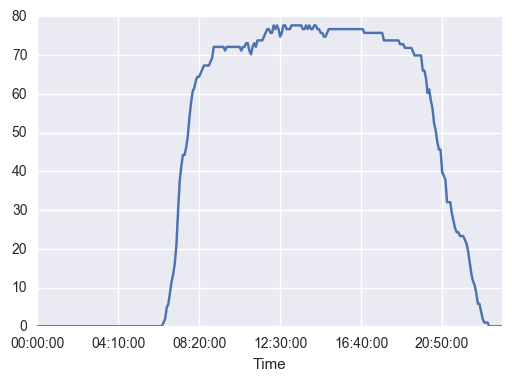

In [62]:
complete_with_meta[(complete_with_meta.Station == 1125897) & (complete_with_meta.Partition == 'Weekends')]\
    .set_index('Time').Obser.plot()

In [63]:
complete_with_meta[complete_with_meta.Station == 1125897]

,Unnamed: 0,Station,Time,Flow,Speed,Occu,Obser,Partition,Fwy,Dir,...,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Name,Lanes,Type
361783,361783,1125897,00:00:00,37.360153,68.282759,0.015205,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
361844,361844,1125897,00:05:00,40.593870,68.276245,0.016226,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
361905,361905,1125897,00:10:00,40.666667,68.292337,0.016720,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
361966,361966,1125897,00:15:00,38.885057,68.229119,0.015503,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
362027,362027,1125897,00:20:00,36.463602,68.143295,0.014539,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
362088,362088,1125897,00:25:00,33.777778,68.016475,0.013741,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
362149,362149,1125897,00:30:00,32.026820,67.959004,0.013298,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
362210,362210,1125897,00:35:00,30.961686,67.854406,0.012663,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
362271,362271,1125897,00:40:00,29.697318,67.904598,0.012485,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML
362332,362332,1125897,00:45:00,30.026820,67.860920,0.011916,0.000000,Weekdays,805,S,...,11,73,66000.0,27.631,27.482,32.89464,-117.214497,805 SB Bypass N/O,2,ML


In [20]:
complete_with_meta[['Station', 'Time', 'Flow', 'Speed', 'Occu', 'Obser', 'Partition']]\
    .groupby(['Station', 'Partition']).head()

,Station,Time,Flow,Speed,Occu,Obser,Partition
0,1108299,00:00:00,23.770115,66.016858,0.007269,95.019157,Weekdays
1,1108372,00:00:00,59.704981,67.326054,0.017446,95.785441,Weekdays
2,1111555,00:00:00,23.716475,65.368199,0.006160,95.275862,Weekdays
3,1111557,00:00:00,28.586207,66.914943,0.006476,95.785441,Weekdays
4,1112964,00:00:00,37.103448,68.064368,0.011172,93.103448,Weekdays
5,1113017,00:00:00,38.762452,67.921456,0.012292,90.804598,Weekdays
6,1113147,00:00:00,46.957854,67.820690,0.014217,95.785441,Weekdays
7,1113159,00:00:00,48.114943,68.051724,0.014898,95.402299,Weekdays
8,1113187,00:00:00,20.624521,68.314943,0.005607,95.022989,Weekdays
9,1113222,00:00:00,16.613027,65.970115,0.004706,95.659004,Weekdays


In [23]:
filter_complete = complete_with_meta[['Time', 'Flow', 'Speed', 'Occu', 'Obser', 'Partition']]

In [137]:
filter_complete.columns

Index([u'Time', u'Flow', u'Speed', u'Occu', u'Obser', u'Partition'], dtype='object')

In [142]:
weekdays = filter_complete[filter_complete.Partition == 'Weekdays'].pivot_table(
    index='Time', values=['Flow', 'Speed', 'Occu', 'Obser'], aggfunc=np.mean)
weekdays['Partition'] = pd.Series(['Weekdays']*weekdays.shape[0], index=weekdays.index)
weekends = filter_complete[filter_complete.Partition == 'Weekends'].pivot_table(
    index='Time', values=['Flow', 'Speed', 'Occu', 'Obser'], aggfunc=np.mean)
weekends['Partition'] = pd.Series(['Weekends']*weekdays.shape[0], index=weekdays.index)

In [147]:
new_summary = pd.concat([weekdays, weekends])

In [49]:
summary = filter_complete.pivot_table(index='Time', columns=['Partition'], 
                                      values=['Flow', 'Speed', 'Occu', 'Obser'], aggfunc=np.mean)

In [50]:
summary.head()

Flow                  Speed                 Occu            \
Partition   Weekdays    Weekends   Weekdays   Weekends  Weekdays  Weekends   
Time                                                                         
00:00:00   65.399226  104.966540  68.326844  68.442483  0.014966  0.022835   
00:05:00   65.008412  102.750432  68.138452  68.226525  0.014898  0.022343   
00:10:00   64.698477  101.200919  68.046251  68.127637  0.014859  0.021986   
00:15:00   62.081305   97.796589  67.979776  68.072495  0.014330  0.021362   
00:20:00   58.654692   93.229651  67.922367  68.029954  0.013630  0.020403   

               Obser             
Partition   Weekdays   Weekends  
Time                             
00:00:00   83.120572  83.385654  
00:05:00   83.468771  83.359016  
00:10:00   83.797833  83.380494  
00:15:00   83.438428  83.353866  
00:20:00   83.499479  83.353627

In [122]:
# new_col = []
# for item1, item2 in zip(summary.columns.get_level_values(1), summary.columns.get_level_values(0)):
#     new_col.append('%s_%s' % (item1, item2))

In [145]:
# new_summary = summary.copy()
# new_summary.columns = new_col
# new_summary.head()

In [146]:
# new_summary.count()

In [148]:
# filter_complete.to_csv('2015_average.csv')
new_summary.to_csv('2015_average_summary.csv')

In [150]:
test = pd.read_csv('2015_average_summary.csv')
test[test.Partition == 'Weekends']

,Time,Flow,Obser,Occu,Speed,Partition
288,00:00:00,104.966540,83.385654,0.022835,68.442483,Weekends
289,00:05:00,102.750432,83.359016,0.022343,68.226525,Weekends
290,00:10:00,101.200919,83.380494,0.021986,68.127637,Weekends
291,00:15:00,97.796589,83.353866,0.021362,68.072495,Weekends
292,00:20:00,93.229651,83.353627,0.020403,68.029954,Weekends
293,00:25:00,88.683986,83.368852,0.019468,68.013068,Weekends
294,00:30:00,84.677957,82.482640,0.018649,68.011485,Weekends
295,00:35:00,81.222471,83.355776,0.017929,67.978734,Weekends
296,00:40:00,78.480036,83.343197,0.017369,67.967499,Weekends
297,00:45:00,75.416346,83.329747,0.016724,67.967714,Weekends


In [128]:
print test.count()

Time              288
Weekdays_Flow     288
Weekends_Flow     288
Weekdays_Speed    288
Weekends_Speed    288
Weekdays_Occu     288
Weekends_Occu     288
Weekdays_Obser    288
Weekends_Obser    288
dtype: int64


In [129]:
summary.columns

MultiIndex(levels=[[u'Flow', u'Speed', u'Occu', u'Obser'], [u'Weekdays', u'Weekends']],
           labels=[[0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 0, 1, 0, 1, 0, 1]],
           names=[None, u'Partition'])

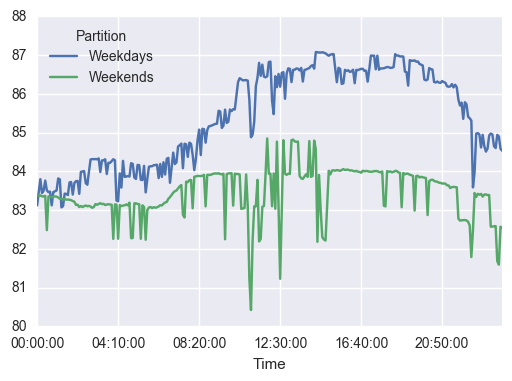

In [130]:
summary.Obser.plot()